In [78]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import numpy as np

import pandas as pd


data = pd.read_csv('train.csv',sep=';')
data.drop(['<TICKER>','<PER>','<TIME>'],axis=1,inplace=True)
data


,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,230502,242.20,245.00,237.40,242.62,83246880
1,230503,242.85,242.99,234.00,235.77,76740930
2,230504,236.51,239.74,236.05,238.89,53006840
3,230505,239.19,240.66,237.30,237.70,61314710
4,230508,238.65,239.86,237.36,238.27,47676110
...,...,...,...,...,...,...
132,231106,269.00,273.87,268.62,273.42,29231770
133,231107,273.08,274.78,272.20,273.31,32183320
134,231108,273.53,278.35,273.28,278.15,58000060
135,231109,278.60,278.85,276.02,276.65,28258660


In [79]:


# Преобразование столбца с датой в формат datetime
data['<DATE>'] = pd.to_datetime(data['<DATE>'], format='%y%m%d')

# Сортировка данных по столбцу с датой
data = data.sort_values(by='<DATE>')

# Добавление значений за пять дней назад для каждого столбца
columns_to_shift = ['<CLOSE>', '<HIGH>', '<LOW>', '<VOL>']
for col in columns_to_shift:
    for i in range(1, 6):
        data[f'{col}_{i}d_ago'] = data[col].shift(i)

# Вывод измененного DataFrame
data.dropna(inplace=True)
data

,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<CLOSE>_1d_ago,<CLOSE>_2d_ago,<CLOSE>_3d_ago,<CLOSE>_4d_ago,...,<LOW>_1d_ago,<LOW>_2d_ago,<LOW>_3d_ago,<LOW>_4d_ago,<LOW>_5d_ago,<VOL>_1d_ago,<VOL>_2d_ago,<VOL>_3d_ago,<VOL>_4d_ago,<VOL>_5d_ago
5,2023-05-10,216.51,227.50,215.70,227.06,154134860,238.27,237.70,238.89,235.77,...,237.36,237.30,236.05,234.00,237.40,47676110.0,61314710.0,53006840.0,76740930.0,83246880.0
6,2023-05-11,228.57,235.38,223.94,229.32,197037380,227.06,238.27,237.70,238.89,...,215.70,237.36,237.30,236.05,234.00,154134860.0,47676110.0,61314710.0,53006840.0,76740930.0
7,2023-05-12,231.05,232.47,226.15,229.29,69831820,229.32,227.06,238.27,237.70,...,223.94,215.70,237.36,237.30,236.05,197037380.0,154134860.0,47676110.0,61314710.0,53006840.0
8,2023-05-15,230.54,231.75,228.52,231.70,48873370,229.29,229.32,227.06,238.27,...,226.15,223.94,215.70,237.36,237.30,69831820.0,197037380.0,154134860.0,47676110.0,61314710.0
9,2023-05-16,232.40,232.86,229.57,230.62,36429340,231.70,229.29,229.32,227.06,...,228.52,226.15,223.94,215.70,237.36,48873370.0,69831820.0,197037380.0,154134860.0,47676110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2023-11-06,269.00,273.87,268.62,273.42,29231770,268.54,269.06,269.68,268.35,...,267.20,268.50,267.60,266.87,268.60,20968810.0,25499750.0,20587810.0,26117980.0,33261680.0
133,2023-11-07,273.08,274.78,272.20,273.31,32183320,273.42,268.54,269.06,269.68,...,268.62,267.20,268.50,267.60,266.87,29231770.0,20968810.0,25499750.0,20587810.0,26117980.0
134,2023-11-08,273.53,278.35,273.28,278.15,58000060,273.31,273.42,268.54,269.06,...,272.20,268.62,267.20,268.50,267.60,32183320.0,29231770.0,20968810.0,25499750.0,20587810.0
135,2023-11-09,278.60,278.85,276.02,276.65,28258660,278.15,273.31,273.42,268.54,...,273.28,272.20,268.62,267.20,268.50,58000060.0,32183320.0,29231770.0,20968810.0,25499750.0


In [80]:
target_data = torch.tensor(data['<CLOSE>'].values, dtype=torch.float32).view(-1, 1)
data.drop(['<CLOSE>','<OPEN>','<HIGH>','<LOW>','<VOL>'],axis=1,inplace=True)
data

,<DATE>,<CLOSE>_1d_ago,<CLOSE>_2d_ago,<CLOSE>_3d_ago,<CLOSE>_4d_ago,<CLOSE>_5d_ago,<HIGH>_1d_ago,<HIGH>_2d_ago,<HIGH>_3d_ago,<HIGH>_4d_ago,...,<LOW>_1d_ago,<LOW>_2d_ago,<LOW>_3d_ago,<LOW>_4d_ago,<LOW>_5d_ago,<VOL>_1d_ago,<VOL>_2d_ago,<VOL>_3d_ago,<VOL>_4d_ago,<VOL>_5d_ago
5,2023-05-10,238.27,237.70,238.89,235.77,242.62,239.86,240.66,239.74,242.99,...,237.36,237.30,236.05,234.00,237.40,47676110.0,61314710.0,53006840.0,76740930.0,83246880.0
6,2023-05-11,227.06,238.27,237.70,238.89,235.77,227.50,239.86,240.66,239.74,...,215.70,237.36,237.30,236.05,234.00,154134860.0,47676110.0,61314710.0,53006840.0,76740930.0
7,2023-05-12,229.32,227.06,238.27,237.70,238.89,235.38,227.50,239.86,240.66,...,223.94,215.70,237.36,237.30,236.05,197037380.0,154134860.0,47676110.0,61314710.0,53006840.0
8,2023-05-15,229.29,229.32,227.06,238.27,237.70,232.47,235.38,227.50,239.86,...,226.15,223.94,215.70,237.36,237.30,69831820.0,197037380.0,154134860.0,47676110.0,61314710.0
9,2023-05-16,231.70,229.29,229.32,227.06,238.27,231.75,232.47,235.38,227.50,...,228.52,226.15,223.94,215.70,237.36,48873370.0,69831820.0,197037380.0,154134860.0,47676110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2023-11-06,268.54,269.06,269.68,268.35,269.89,269.78,270.98,270.30,270.50,...,267.20,268.50,267.60,266.87,268.60,20968810.0,25499750.0,20587810.0,26117980.0,33261680.0
133,2023-11-07,273.42,268.54,269.06,269.68,268.35,273.87,269.78,270.98,270.30,...,268.62,267.20,268.50,267.60,266.87,29231770.0,20968810.0,25499750.0,20587810.0,26117980.0
134,2023-11-08,273.31,273.42,268.54,269.06,269.68,274.78,273.87,269.78,270.98,...,272.20,268.62,267.20,268.50,267.60,32183320.0,29231770.0,20968810.0,25499750.0,20587810.0
135,2023-11-09,278.15,273.31,273.42,268.54,269.06,278.35,274.78,273.87,269.78,...,273.28,272.20,268.62,267.20,268.50,58000060.0,32183320.0,29231770.0,20968810.0,25499750.0


In [81]:
data['<DATE>'] = pd.to_datetime(data['<DATE>']).astype(np.int64)
data.dtypes

<DATE>              int64
<CLOSE>_1d_ago    float64
<CLOSE>_2d_ago    float64
<CLOSE>_3d_ago    float64
<CLOSE>_4d_ago    float64
<CLOSE>_5d_ago    float64
<HIGH>_1d_ago     float64
<HIGH>_2d_ago     float64
<HIGH>_3d_ago     float64
<HIGH>_4d_ago     float64
<HIGH>_5d_ago     float64
<LOW>_1d_ago      float64
<LOW>_2d_ago      float64
<LOW>_3d_ago      float64
<LOW>_4d_ago      float64
<LOW>_5d_ago      float64
<VOL>_1d_ago      float64
<VOL>_2d_ago      float64
<VOL>_3d_ago      float64
<VOL>_4d_ago      float64
<VOL>_5d_ago      float64
dtype: object

In [82]:

data = data.values.astype('float32')
data

array([[1.6836768e+18, 2.3827000e+02, 2.3770000e+02, ..., 5.3006840e+07,
        7.6740928e+07, 8.3246880e+07],
       [1.6837632e+18, 2.2706000e+02, 2.3827000e+02, ..., 6.1314712e+07,
        5.3006840e+07, 7.6740928e+07],
       [1.6838496e+18, 2.2932001e+02, 2.2706000e+02, ..., 4.7676112e+07,
        6.1314712e+07, 5.3006840e+07],
       ...,
       [1.6994016e+18, 2.7331000e+02, 2.7342001e+02, ..., 2.0968810e+07,
        2.5499750e+07, 2.0587810e+07],
       [1.6994880e+18, 2.7814999e+02, 2.7331000e+02, ..., 2.9231770e+07,
        2.0968810e+07, 2.5499750e+07],
       [1.6995744e+18, 2.7664999e+02, 2.7814999e+02, ..., 3.2183320e+07,
        2.9231770e+07, 2.0968810e+07]], dtype=float32)

In [116]:
data.shape

(132, 21)

In [152]:
import torch
import torch.nn as nn
from tqdm import tqdm

# Define the LSTM model architecture
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq), 1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions

# Set up the model
input_size = 21  # Assuming 21 features/columns in your data
hidden_size = 64  # Number of LSTM units
output_size = 1  # Single output for predicting <CLOSE>

model = LSTMModel(input_size, hidden_size, output_size)

import numpy as np
from sklearn.model_selection import train_test_split

# Assuming 'data' contains your entire dataset
# Split data into features (X) and target variable (y)
X = data[:, 1:]  # Exclude the timestamp column if it's the first column
y = target_data

# Split data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert training and testing data to PyTorch tensors
train_input = torch.tensor(X_train, dtype=torch.float32)
train_target = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

test_input = torch.tensor(X_test, dtype=torch.float32)
test_target = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10000
batch_size = 5  # Batch size of 5

# Train the model
for epoch in range(num_epochs):
    for i in range(0, len(train_input), batch_size):
        # Create batches
        input_batch = train_input[i:i+batch_size]
        target_batch = train_target[i:i+batch_size]
        # Forward pass
        outputs = model(input_batch)
        
        if epoch % 1000 == 0:
            print(target_batch)
            print("res:",outputs)
        loss = criterion(outputs, target_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print training statistics
    if epoch % 1000 == 0:  # Print every 1000 epochs, adjust as needed
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training finished')





tensor([[250.1600],
        [251.9900],
        [227.0600],
        [248.1000],
        [268.5400]])
res: tensor([[ 0.2084],
        [-0.1012],
        [-0.0546],
        [-0.0318],
        [-0.0913]], grad_fn=<AddmmBackward0>)
tensor([[258.5000],
        [244.6000],
        [264.8500],
        [267.9000],
        [244.1300]])
res: tensor([[-0.0906],
        [ 0.0638],
        [-0.1381],
        [ 0.2547],
        [ 0.2273]], grad_fn=<AddmmBackward0>)
tensor([[246.1700],
        [265.6800],
        [260.4200],
        [240.4000],
        [246.1900]])
res: tensor([[ 0.0237],
        [ 0.0747],
        [-0.0482],
        [ 0.1888],
        [ 0.0410]], grad_fn=<AddmmBackward0>)
tensor([[266.2300],
        [258.1800],
        [240.6600],
        [269.8900],
        [258.7900]])
res: tensor([[ 0.2221],
        [ 0.3242],
        [ 0.0673],
        [-0.1171],
        [ 0.0076]], grad_fn=<AddmmBackward0>)
tensor([[236.4300],
        [241.2100],
        [260.4500],
        [245.1800],
        

In [102]:
test_data = pd.read_csv('test.csv',sep=';')
test_data.drop(['<TICKER>','<PER>','<TIME>'],axis=1,inplace=True)
test_data

,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,231108,273.53,278.35,273.28,278.15,58000060
1,231109,278.60,278.85,276.02,276.65,28258660
2,231110,276.99,281.30,276.60,280.19,44600220
3,231113,280.40,284.80,280.32,283.97,45780320
4,231114,283.66,283.88,280.54,280.87,40350240
5,231115,280.87,283.93,278.51,282.89,41784490
6,231116,282.40,283.69,279.56,279.70,24654700
7,231117,279.69,282.50,278.66,281.60,31282610


In [103]:


# Преобразование столбца с датой в формат datetime
test_data['<DATE>'] = pd.to_datetime(test_data['<DATE>'], format='%y%m%d')

# Сортировка данных по столбцу с датой
test_data = test_data.sort_values(by='<DATE>')

# Добавление значений за пять дней назад для каждого столбца
columns_to_shift = ['<CLOSE>', '<HIGH>', '<LOW>', '<VOL>']
for col in columns_to_shift:
    for i in range(1, 6):
        test_data[f'{col}_{i}d_ago'] = test_data[col].shift(i)

# Вывод измененного DataFrame
test_data.dropna(inplace=True)
test_data

,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<CLOSE>_1d_ago,<CLOSE>_2d_ago,<CLOSE>_3d_ago,<CLOSE>_4d_ago,...,<LOW>_1d_ago,<LOW>_2d_ago,<LOW>_3d_ago,<LOW>_4d_ago,<LOW>_5d_ago,<VOL>_1d_ago,<VOL>_2d_ago,<VOL>_3d_ago,<VOL>_4d_ago,<VOL>_5d_ago
5,2023-11-15,280.87,283.93,278.51,282.89,41784490,280.87,283.97,280.19,276.65,...,280.54,280.32,276.60,276.02,273.28,40350240.0,45780320.0,44600220.0,28258660.0,58000060.0
6,2023-11-16,282.40,283.69,279.56,279.70,24654700,282.89,280.87,283.97,280.19,...,278.51,280.54,280.32,276.60,276.02,41784490.0,40350240.0,45780320.0,44600220.0,28258660.0
7,2023-11-17,279.69,282.50,278.66,281.60,31282610,279.70,282.89,280.87,283.97,...,279.56,278.51,280.54,280.32,276.60,24654700.0,41784490.0,40350240.0,45780320.0,44600220.0


In [104]:
target_test_data = torch.tensor(test_data['<CLOSE>'].values, dtype=torch.float32).view(-1, 1)
test_data.drop(['<CLOSE>','<OPEN>','<HIGH>','<LOW>','<VOL>'],axis=1,inplace=True)
test_data['<DATE>'] = pd.to_datetime(test_data['<DATE>']).astype(np.int64)
test_data.dtypes
test_data = test_data.values.astype('float32')
test_data

array([[1.7000065e+18, 2.8087000e+02, 2.8397000e+02, 2.8019000e+02,
        2.7664999e+02, 2.7814999e+02, 2.8388000e+02, 2.8479999e+02,
        2.8129999e+02, 2.7885001e+02, 2.7835001e+02, 2.8054001e+02,
        2.8032001e+02, 2.7660001e+02, 2.7601999e+02, 2.7328000e+02,
        4.0350240e+07, 4.5780320e+07, 4.4600220e+07, 2.8258660e+07,
        5.8000060e+07],
       [1.7000928e+18, 2.8289001e+02, 2.8087000e+02, 2.8397000e+02,
        2.8019000e+02, 2.7664999e+02, 2.8392999e+02, 2.8388000e+02,
        2.8479999e+02, 2.8129999e+02, 2.7885001e+02, 2.7851001e+02,
        2.8054001e+02, 2.8032001e+02, 2.7660001e+02, 2.7601999e+02,
        4.1784488e+07, 4.0350240e+07, 4.5780320e+07, 4.4600220e+07,
        2.8258660e+07],
       [1.7001792e+18, 2.7970001e+02, 2.8289001e+02, 2.8087000e+02,
        2.8397000e+02, 2.8019000e+02, 2.8369000e+02, 2.8392999e+02,
        2.8388000e+02, 2.8479999e+02, 2.8129999e+02, 2.7956000e+02,
        2.7851001e+02, 2.8054001e+02, 2.8032001e+02, 2.7660001e+02,


In [153]:
# Set the model in evaluation mode
model.eval()

# Make predictions on the test data
with torch.no_grad():
    test_outputs = model(test_input)

predicted_values = test_outputs.numpy()


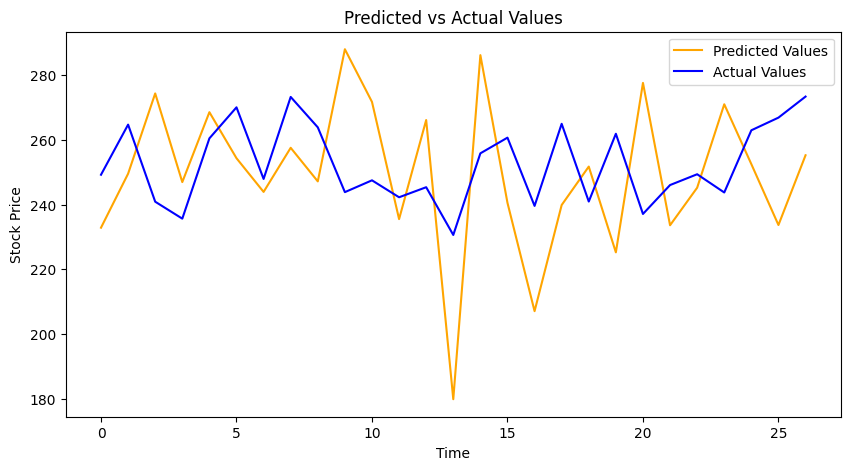

In [156]:
# predicted_values
import matplotlib.pyplot as plt

# Assuming fc_series contains your predicted values and y_test contains your actual test values

# Plotting predicted values and actual test values
plt.figure(figsize=(10, 5))
plt.plot(predicted_values, label='Predicted Values', color='orange')
plt.plot(y_test, label='Actual Values', color='blue')

plt.title('Predicted vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
